# Imports

In [1]:
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings('ignore')

# Configs

In [3]:
INPUT_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/features_df_phase2.parquet'
Ridge_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/Ridge_feature_predictions_phase2.parquet'
RF_ridge_PATH = '/Users/maedeh/Desktop/data/RF_ridge_predictions_loc_phase2.parquet'
RF_PATH = '/Users/maedeh/Desktop/data/RF_predictions_loc_phase2.parquet'



FEATURE_LIST = ['day_of_week',
                'day_of_month',

                'max_previous_week_interval',
                'max_previous_7exact_interval',
    
                'previous_day_9interval',
                'previous_day_10interval',
                'previous_day_14interval',
                'previous_day_15interval',
                'previous_day_17interval',

                'avrg_previous_2day_8interval',
                
                'diff_previous_2day_interval',
                'diff_previous_2day_previous_interval',
    
                'previous_day_interval',
                'previous_2day_interval',
                'previous_3day_interval',
                'previous_4day_interval',
                'previous_5day_interval',
                'previous_6day_interval',
                'previous_week_interval',
                'previous_8day_interval',
                'previous_9day_interval',
                'previous_10day_interval',
                'previous_11day_interval',
                'previous_12day_interval',
                'previous_13day_interval',
                'previous_2week_interval'
               ]


TEST_START_DATE = '2023-04-1'
VALIDATION_START_DATE = '2023-03-18'

NUM_INTERVAL_PER_DAY = 8
HIGH_DEMAND_NUMS = 40
SORT_METHOD = 'mean'

AUTO_TUNE = False
add_ridge_feature = True

# Data preparation


## Load Data

In [4]:
features_df = pd.read_parquet(INPUT_PATH, engine='pyarrow')

In [5]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (251520, 7)


,Location,Date,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval
0,1,2023-01-01,0,0.0,NaN,NaN,NaN
1,1,2023-01-01,3,1.0,NaN,NaN,NaN
2,1,2023-01-01,6,1.0,NaN,NaN,NaN
3,1,2023-01-01,9,1.0,NaN,NaN,NaN
4,1,2023-01-01,12,13.0,NaN,NaN,NaN


In [6]:
ridge_df = pd.read_parquet(Ridge_PATH, engine='pyarrow')

In [7]:
print(f'rides dataframe shape : {ridge_df.shape}')
ridge_df.head()

rides dataframe shape : (222176, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-01-15,0,-0.046404
1,1,2023-01-15,3,0.610225
2,1,2023-01-15,6,2.055764
3,1,2023-01-15,9,1.146677
4,1,2023-01-15,12,5.979035


## Add feature

In [8]:
def add_feature(dataset, lag_num):
    
    for i in range(1,lag_num):
        if i not in(1,7):
            dataset[f'previous_{i}day_interval'] = dataset.groupby('Location')['Demand'].shift(i*NUM_INTERVAL_PER_DAY)

    
    dataset['day_of_week'] = dataset['Date'].dt.dayofweek
    dataset['day_of_month'] = dataset['Date'].dt.day
    dataset['time'] = dataset['Hour_interval']
    dataset['zone'] = dataset['Location']

    
    dataset['max_previous_week_interval'] = dataset.groupby('Location')['Demand'].rolling(window = 7*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)
    dataset['max_previous_2week_interval'] = dataset.groupby('Location')['Demand'].rolling(window = 14*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)

    
    df = dataset.sort_values(['Location','Hour_interval','Date'])[['Location','Hour_interval','Date','Demand']]
    df['max_previous_7exact_interval'] = dataset.groupby(['Location','Hour_interval'])['Demand'].rolling(window = 7).max().values
    dataset['max_previous_7exact_interval'] = df.sort_values(['Location', 'Date','Hour_interval'])['max_previous_7exact_interval']
    df['max_previous_14exact_interval'] = dataset.groupby(['Location','Hour_interval'])['Demand'].rolling(window = 14).max().values
    dataset['max_previous_14exact_interval'] = df.sort_values(['Location', 'Date','Hour_interval'])['max_previous_14exact_interval']

    
    dataset['previous_day_9interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+1)
    dataset['previous_day_10interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+2)
    dataset['previous_day_11interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+3)
    dataset['previous_day_12interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+4)
    dataset['previous_day_13interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+5)
    dataset['previous_day_14interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+6)
    dataset['previous_day_15interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+7)
    dataset['previous_day_17interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+9)

    
    dataset['avrg_previous_2day_8interval'] = (8*dataset['previous_day_9interval']+7*dataset['previous_day_10interval']+\
    6*dataset['previous_day_11interval']+5*dataset['previous_day_12interval']+4*dataset['previous_day_13interval']+\
    3*dataset['previous_day_14interval']+2*dataset['previous_day_15interval']+dataset['previous_2week_interval'])/NUM_INTERVAL_PER_DAY

    
    dataset['diff_previous_2day_previous_interval'] = dataset['previous_day_17interval']-dataset['previous_day_9interval']

    
    dataset['diff_previous_2day_interval'] = dataset['previous_day_interval']-dataset['previous_2day_interval']
    dataset['diff_previous_2week_interval'] = dataset['previous_week_interval']-dataset['previous_2week_interval']

    
    return dataset



In [9]:
new_features_df = add_feature(features_df, lag_num = 14)
print(f'new features dataframe shape : {new_features_df.shape}')
new_features_df.head()

new features dataframe shape : (251520, 38)


,Location,Date,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval,previous_2day_interval,previous_3day_interval,previous_4day_interval,...,previous_day_11interval,previous_day_12interval,previous_day_13interval,previous_day_14interval,previous_day_15interval,previous_day_17interval,avrg_previous_2day_8interval,diff_previous_2day_previous_interval,diff_previous_2day_interval,diff_previous_2week_interval
0,1,2023-01-01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-01-01,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2023-01-01,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2023-01-01,9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2023-01-01,12,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def feature_selection(dataset, FEATURE_LIST):
    
    dataset = dataset[['Location','Date','Hour_interval','Demand']+FEATURE_LIST]
    dataset.dropna(inplace = True)
    
    return dataset

In [11]:
selected_features_df = feature_selection(new_features_df, FEATURE_LIST)
print(f'features dataframe shape : {selected_features_df.shape}')
selected_features_df.head()

features dataframe shape : (222176, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
112,1,2023-01-15,0,0.0,6,15,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
113,1,2023-01-15,3,2.0,6,15,14.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
114,1,2023-01-15,6,1.0,6,15,14.0,2.0,0.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
115,1,2023-01-15,9,0.0,6,15,14.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
116,1,2023-01-15,12,8.0,6,15,14.0,8.0,1.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


In [12]:
def join_ridge_feature(dataset, ridge_df, FEATURE_LIST):

    dataset = dataset.merge(ridge_df, how='outer', on = ['Location','Date','Hour_interval'])
    FEATURE_LIST.append('Predicted_demand')
    
    return dataset, FEATURE_LIST

In [13]:
if add_ridge_feature:
    selected_features_df, FEATURE_LIST = join_ridge_feature(selected_features_df, ridge_df, FEATURE_LIST)
    print(f'final features dataframe shape : {selected_features_df.shape}')
selected_features_df.head()

final features dataframe shape : (222176, 31)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Predicted_demand
0,1,2023-01-15,0,0.0,6,15,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.046404
1,1,2023-01-15,3,2.0,6,15,14.0,2.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,0.610225
2,1,2023-01-15,6,1.0,6,15,14.0,2.0,0.0,0.0,...,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0,2.055764
3,1,2023-01-15,9,0.0,6,15,14.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0,1.146677
4,1,2023-01-15,12,8.0,6,15,14.0,8.0,1.0,1.0,...,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0,5.979035


## Split Train and Test Data

In [14]:
def high_demand_split(dataset):
    high_index = dataset.groupby(['Location'])['Demand'].aggregate([SORT_METHOD]).sort_values(SORT_METHOD,ascending=False).reset_index()
    high_demand_df = dataset[dataset['Location'].isin(high_index['Location'][:HIGH_DEMAND_NUMS])]
    return high_demand_df

In [15]:
High_demand_df = high_demand_split(selected_features_df)
print(f'High_demand_selected_feature dataframe shape : {High_demand_df.shape}')
High_demand_df.head()

High_demand_selected_feature dataframe shape : (33920, 31)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Predicted_demand
35616,43,2023-01-15,0,27.0,6,15,652.0,27.0,132.0,341.0,...,3.0,23.0,28.0,11.0,6.0,5.0,1.0,4.0,204.0,-0.585226
35617,43,2023-01-15,3,2.0,6,15,652.0,10.0,17.0,132.0,...,3.0,8.0,5.0,6.0,3.0,2.0,5.0,3.0,23.0,-0.585226
35618,43,2023-01-15,6,39.0,6,15,652.0,158.0,8.0,17.0,...,102.0,48.0,51.0,105.0,134.0,112.0,120.0,31.0,28.0,-0.659239
35619,43,2023-01-15,9,182.0,6,15,652.0,267.0,38.0,8.0,...,224.0,181.0,209.0,257.0,248.0,255.0,233.0,142.0,101.0,-0.585226
35620,43,2023-01-15,12,478.0,6,15,652.0,503.0,206.0,38.0,...,361.0,446.0,480.0,473.0,541.0,376.0,421.0,450.0,306.0,-0.585226


In [16]:
def train_test_splitting(dataset, START_DATE):

    train_df = dataset[dataset['Date'] < START_DATE]
    test_df = dataset[dataset['Date'] >= START_DATE]

    return train_df, test_df

In [17]:
train_df, test_df = train_test_splitting(High_demand_df, TEST_START_DATE)

In [18]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (24320, 31)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Predicted_demand
35616,43,2023-01-15,0,27.0,6,15,652.0,27.0,132.0,341.0,...,3.0,23.0,28.0,11.0,6.0,5.0,1.0,4.0,204.0,-0.585226
35617,43,2023-01-15,3,2.0,6,15,652.0,10.0,17.0,132.0,...,3.0,8.0,5.0,6.0,3.0,2.0,5.0,3.0,23.0,-0.585226
35618,43,2023-01-15,6,39.0,6,15,652.0,158.0,8.0,17.0,...,102.0,48.0,51.0,105.0,134.0,112.0,120.0,31.0,28.0,-0.659239
35619,43,2023-01-15,9,182.0,6,15,652.0,267.0,38.0,8.0,...,224.0,181.0,209.0,257.0,248.0,255.0,233.0,142.0,101.0,-0.585226
35620,43,2023-01-15,12,478.0,6,15,652.0,503.0,206.0,38.0,...,361.0,446.0,480.0,473.0,541.0,376.0,421.0,450.0,306.0,-0.585226


In [19]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (9600, 31)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Predicted_demand
36224,43,2023-04-01,0,27.0,5,1,684.0,29.0,116.0,249.0,...,29.0,27.0,16.0,8.0,12.0,7.0,7.0,31.0,21.0,-0.625546
36225,43,2023-04-01,3,4.0,5,1,684.0,10.0,18.0,116.0,...,10.0,6.0,8.0,4.0,2.0,5.0,1.0,3.0,4.0,-0.395127
36226,43,2023-04-01,6,58.0,5,1,684.0,123.0,8.0,18.0,...,33.0,22.0,75.0,82.0,114.0,112.0,91.0,46.0,50.0,0.605740
36227,43,2023-04-01,9,223.0,5,1,684.0,309.0,102.0,8.0,...,224.0,229.0,296.0,341.0,256.0,295.0,266.0,263.0,221.0,-0.062444
36228,43,2023-04-01,12,449.0,5,1,684.0,478.0,244.0,102.0,...,478.0,616.0,428.0,462.0,356.0,388.0,375.0,420.0,456.0,-0.554174


In [20]:
gridsearch_train_df, validation_df = train_test_splitting(train_df, VALIDATION_START_DATE)

In [21]:
print(f'gridsearch_train dataframe shape : {gridsearch_train_df.shape}')
gridsearch_train_df.head()

gridsearch_train dataframe shape : (19840, 31)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Predicted_demand
35616,43,2023-01-15,0,27.0,6,15,652.0,27.0,132.0,341.0,...,3.0,23.0,28.0,11.0,6.0,5.0,1.0,4.0,204.0,-0.585226
35617,43,2023-01-15,3,2.0,6,15,652.0,10.0,17.0,132.0,...,3.0,8.0,5.0,6.0,3.0,2.0,5.0,3.0,23.0,-0.585226
35618,43,2023-01-15,6,39.0,6,15,652.0,158.0,8.0,17.0,...,102.0,48.0,51.0,105.0,134.0,112.0,120.0,31.0,28.0,-0.659239
35619,43,2023-01-15,9,182.0,6,15,652.0,267.0,38.0,8.0,...,224.0,181.0,209.0,257.0,248.0,255.0,233.0,142.0,101.0,-0.585226
35620,43,2023-01-15,12,478.0,6,15,652.0,503.0,206.0,38.0,...,361.0,446.0,480.0,473.0,541.0,376.0,421.0,450.0,306.0,-0.585226


In [22]:
print(f'validation dataframe shape : {validation_df.shape}')
validation_df.head()

validation dataframe shape : (4480, 31)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Predicted_demand
36112,43,2023-03-18,0,21.0,5,18,655.0,34.0,133.0,277.0,...,28.0,21.0,12.0,16.0,7.0,7.0,2.0,25.0,19.0,0.153171
36113,43,2023-03-18,3,4.0,5,18,655.0,11.0,34.0,133.0,...,9.0,4.0,6.0,2.0,6.0,3.0,4.0,1.0,2.0,0.153171
36114,43,2023-03-18,6,50.0,5,18,655.0,167.0,9.0,34.0,...,37.0,43.0,118.0,166.0,146.0,109.0,107.0,49.0,36.0,1.313993
36115,43,2023-03-18,9,221.0,5,18,655.0,314.0,102.0,9.0,...,235.0,205.0,277.0,335.0,328.0,308.0,278.0,239.0,254.0,0.454328
36116,43,2023-03-18,12,456.0,5,18,655.0,515.0,170.0,102.0,...,410.0,464.0,424.0,404.0,359.0,420.0,343.0,501.0,489.0,0.435341


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [23]:
def grid_search(test_parameters, train_data, validation_data, feature_list):
    best_score = float('inf')
    best_params = None
    param_combination = product(*test_parameters.values())
    
    for param in param_combination:

        param_dict = dict(zip(test_parameters.keys(), param))
        model = RandomForestRegressor(**param_dict)
        model.fit(train_data[feature_list], train_data['Demand'])
        
        validation_predict_df = model.predict(validation_data[feature_list])
        score = mean_squared_error(validation_data['Demand'], validation_predict_df)
        
        if score<best_score:
            best_score = score
            best_params = param_dict
            
    return best_params, best_score

In [24]:
if AUTO_TUNE:
    params_test = { 'max_depth' : [10, 11, 12], 
                    'min_samples_leaf' : [1, 5, 10], 
                    'max_features': [0.6, 0.75, 0.9], 
                    'n_estimators' : [300], 
                    'oob_score' : [True]
                }

    best_params, best_score = grid_search(
        test_parameters = params_test,
        train_data = gridsearch_train_df,
        validation_data = validation_df,
        feature_list = FEATURE_LIST
        )
    
    print(best_params, best_score)
else:
    best_params = {
                    'oob_score': True,
                    'max_features': 0.6, 
                    'max_depth': 12, 
                    'min_samples_leaf': 1,
                    'n_estimators': 500
                   }


### Prediction

In [25]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [26]:
model = RandomForestRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [27]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df
    
    train_data = train_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    test_data = test_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby(['Date','Hour_interval'])['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby(['Date','Hour_interval'])['Predicted'].sum()

    plt.figure(figsize=(30,10))
    plt.title('Train', fontsize = 30)
    plt.plot(range(1,len(train_data)+1), train_data)
    plt.plot(range(1,len(train_data)+1), predicted_train_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

    plt.figure(figsize=(30,10))
    plt.title('Test', fontsize = 30)
    plt.plot(range(1,len(test_data)+1), test_data)
    plt.plot(range(1,len(test_data)+1), predicted_test_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

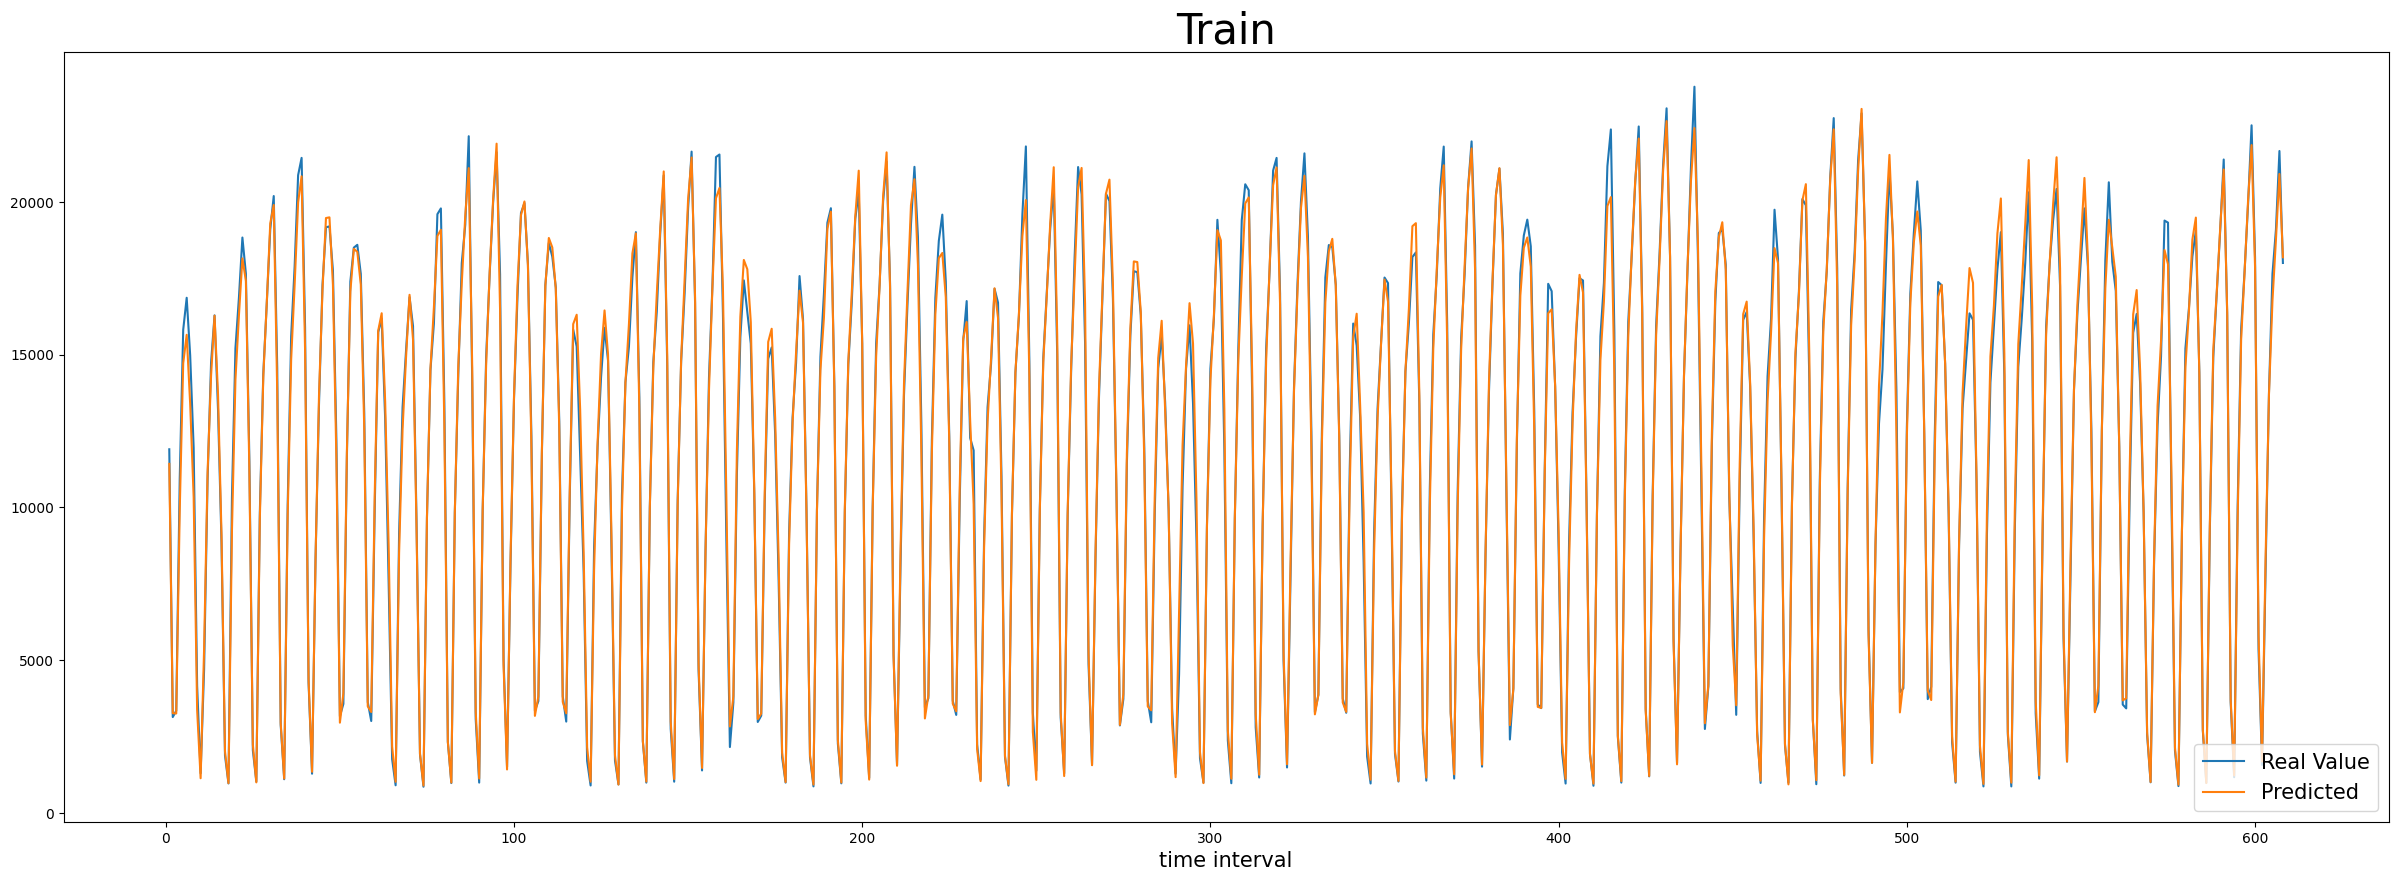

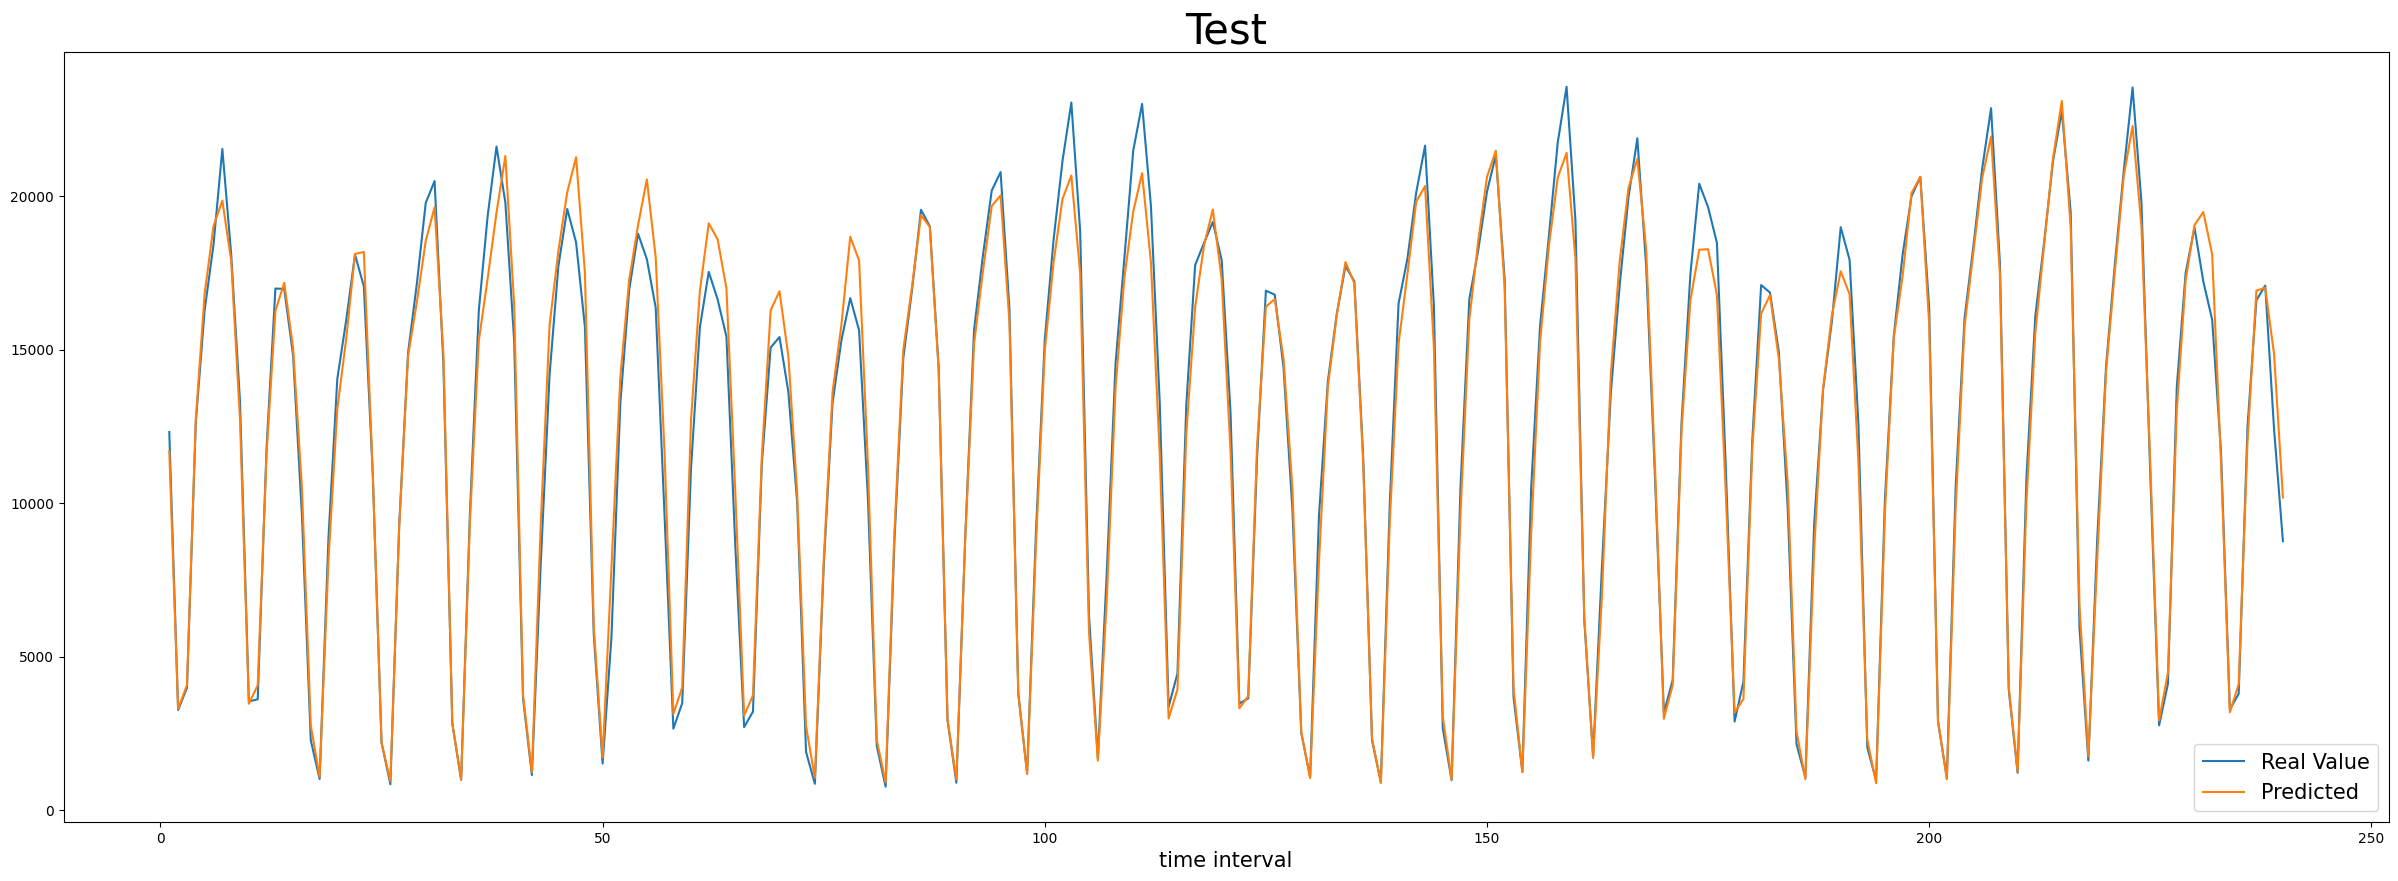

In [28]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [29]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [30]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)


    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)



In [31]:
evaluation('RF', train_df, test_df, train_prediction_df, test_prediction_df)

RF train scores:
MAE : 20.545445007046936
MSE : 917.3093044303665
MAPE : 7613396079042.604
RF test scores:
MAE : 31.421101205226854
MSE : 2442.390508191916
MAPE : 2284913904509.2993


### Feature Importance and SHAPE

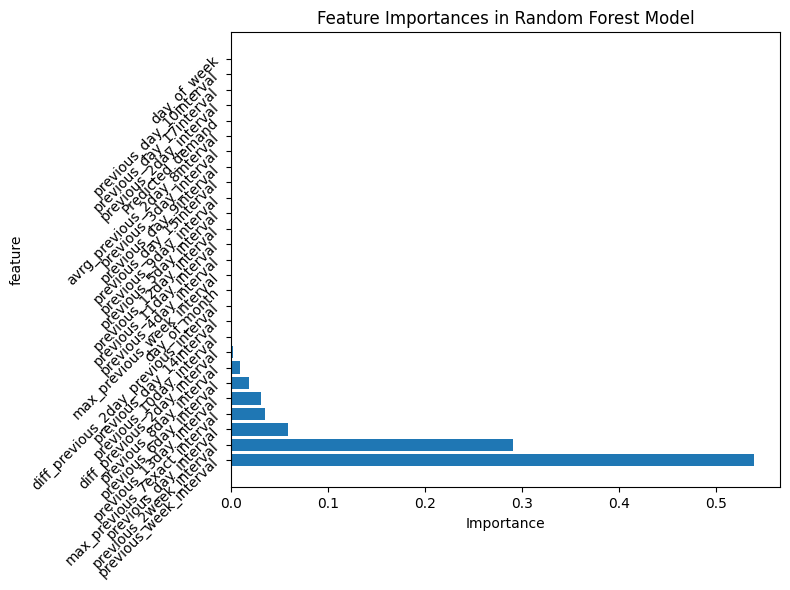

In [32]:
importance = model.feature_importances_
sorted_indices = np.argsort(importance)[::-1]
plt.figure(figsize=(8, 6))
plt.barh(range(len(FEATURE_LIST)), importance[sorted_indices])
plt.yticks(range(len(FEATURE_LIST)), [FEATURE_LIST[i] for i in sorted_indices], rotation=45, ha='right')
plt.xlabel('Importance')
plt.ylabel('feature')
plt.title('Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

# File Saving

In [33]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [34]:
def prediction_labeling(pred_df, labeled_df):
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date', 'Hour_interval']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [35]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)

In [36]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (9600, 4)


,Location,Date,Hour_interval,Predicted_demand
0,43,2023-04-01,0,26.396757
1,43,2023-04-01,3,5.743806
2,43,2023-04-01,6,37.292899
3,43,2023-04-01,9,233.940775
4,43,2023-04-01,12,472.952078


In [37]:
if add_ridge_feature:
    OUTPUT_PATH = RF_ridge_PATH
else:
    OUTPUT_PATH = RF_PATH

save_predictions(labeled_prediction_df, OUTPUT_PATH)